### Performing Regression on Health Insurance Data
This notebook seeks to implement regression and improve ML model accuracy through feature transformation, feature engineering, clustering, algorithm boosting, etc.

Our main objective is to predict insurance charges. We will use regression because our target variable is numeric.

In [1]:
# Importing libraries
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

### 1. Obtaining Data

In [3]:
# Loading the dataset
df_insure = pd.read_csv("C:/Users/Nkululeko Cyril Cele/source/Machine-Learning/insurance.csv")

In [4]:
# Checking the shape of the df
print(f"Rows, columns: {df_insure.shape}\n")

# Showing the first five rows
print(df_insure.head())

Rows, columns: (1338, 7)

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


The dataset has 1338 rows/records, 6 features, and 1 target variable. 3 of the features (sex, smoker, region) are categorical variables and 3 others (age, bmi, children) are numerical.

### 2. Scrubbing Data

- Handling duplicated rows.

In [5]:
# Finding and removing duplicate records
df_insure.duplicated().sum()

1

In [6]:
# Printing the duplicated rows
print(df_insure[df_insure.duplicated(keep = "last")],"\n")
print(df_insure[df_insure.duplicated(keep = "first")])

     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631 

     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


In [7]:
# Removing the duplicate
mask = ~ df_insure.duplicated()
df_insure = df_insure[mask]
print(f"Rows, columns: {df_insure.shape}")

Rows, columns: (1337, 7)


- Handling missing values

In [8]:
# Checking the total number of missing values
df_insure.isnull().values.sum()

0

There are no missing values.

- Checking String-Encoded Categorical Data for Consistency

In [9]:
# Printing unique values for the categorical columns
print(df_insure.sex.unique(), "\n")
print(df_insure.smoker.unique(),"\n")
print(df_insure.region.unique())

['female' 'male'] 

['yes' 'no'] 

['southwest' 'southeast' 'northwest' 'northeast']


The values in these columns are consistent. The sex and the smoker columns have two distinct values, whereas the region column has four.

- Checking Numerical Data for Consistency

In [10]:
# Printing unique values for the numeric columns
print(f"Unique values for the age column:\n{df_insure.age.unique()}\n")
print(f"Unique values for the bmi column:\n{df_insure.bmi.unique()}\n")
print(f"Total number of unique values in the bmi column: {df_insure.bmi.nunique()}\n")
print(f"Unique values for the children column:\n{df_insure.children.unique()}")

Unique values for the age column:
[19 18 28 33 32 31 46 37 60 25 62 23 56 27 52 30 34 59 63 55 22 26 35 24
 41 38 36 21 48 40 58 53 43 64 20 61 44 57 29 45 54 49 47 51 42 50 39]

Unique values for the bmi column:
[27.9   33.77  33.    22.705 28.88  25.74  33.44  27.74  29.83  25.84
 26.22  26.29  34.4   39.82  42.13  24.6   30.78  23.845 40.3   35.3
 36.005 32.4   34.1   31.92  28.025 27.72  23.085 32.775 17.385 36.3
 35.6   26.315 28.6   28.31  36.4   20.425 32.965 20.8   36.67  39.9
 26.6   36.63  21.78  30.8   37.05  37.3   38.665 34.77  24.53  35.2
 35.625 33.63  28.    34.43  28.69  36.955 31.825 31.68  22.88  37.335
 27.36  33.66  24.7   25.935 22.42  28.9   39.1   36.19  23.98  24.75
 28.5   28.1   32.01  27.4   34.01  29.59  35.53  39.805 26.885 38.285
 37.62  41.23  34.8   22.895 31.16  27.2   26.98  39.49  24.795 31.3
 38.28  19.95  19.3   31.6   25.46  30.115 29.92  27.5   28.4   30.875
 27.94  35.09  29.7   35.72  32.205 28.595 49.06  27.17  23.37  37.1
 23.75  28.975 31.35

Everything looks fine. We will not concern ourselves much about these too many unique values. It is a float column.

### 3. Exploratory Data Analysis

- Examining Numeric Columns

In [11]:
# Displaying summary statistics for the numeric columns
df_insure.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


The age range amongst the customers who subscribe for health insurance is 18 - 64, and about 50% of them are clustered around age 39.
About half of these customers are likely to be overweight, or have a BMI index of 30 and above, have at least one kid, and pay approximately $9386 and up for insurance. **Note:** The charges column is highly skewed.

- Detecting the Outliers

In [12]:
# Creating a class that returns lower and upper boundaries
class OutlierBoundary:
    """The class accepts one argument and returns the upper and lower boundaries.
    """
    def __init__(self, dataset):
        """Initiates the class
        """
        self.dataset = dataset

    def outlier(self):
        """The function detects the upper and lower class boundaries
        """
        
        # Creating a list of columns for which to return the upper and lower boundaries
        column_list = ["age", "bmi", "children", "charges"] 
        
        # Iterating over the list of columns
        for column in self.dataset:
            
            # Checking whether the columns in the list are also found in the dataset
            if column in column_list:
                
                # Extracting the summary statistics
                des = self.dataset[column].describe()
                
                # Creating the dictionary that stores the summary statistics
                desPairs = {"count":0,"mean":1,"std":2,"min":3,"25":4,"50":5,"75":6,"max":7}
                
                # Calculating first and third quartiles
                Q1 = des[desPairs["25"]]
                Q3 = des[desPairs["75"]]
                
                # Calculating the inter-quartile range
                IQR = Q3-Q1
                
                # Calculating the lower and upper boundaries
                lower = Q1 - 1.5 * IQR
                upper = Q3 + 1.5 * IQR
                
                # Printing the boundaries for each column
                print(f"The upper boundary for the {column} column is {upper} and the lower boundary is {lower}.")

In [13]:
# Storing the boundaries
p = OutlierBoundary(df_insure)

In [14]:
# Printing the boundaries for our target columns
p.outlier()

The upper boundary for the age column is 87.0 and the lower boundary is -9.0.
The upper boundary for the bmi column is 47.31500000000001 and the lower boundary is 13.674999999999994.
The upper boundary for the children column is 5.0 and the lower boundary is -3.0.
The upper boundary for the charges column is 34524.777625 and the lower boundary is -13120.716174999998.


Any value below the lower boundary and above the upper boundary is treated as an outlier.

In [15]:
# Printing the total estimate of potential outliers
print("The total number of outliers that can be removed is:",
      len(df_insure[df_insure.age > 87.0]) +
      len(df_insure[df_insure.age < -9.0]) +
      len(df_insure[df_insure.bmi > 47.315]) +
      len(df_insure[df_insure.bmi < 13.675]) +
      len(df_insure[df_insure.children > 5.0]) +
      len(df_insure[df_insure.children < -3.0]) +
      len(df_insure[df_insure.charges > 34524.78]) +
      len(df_insure[df_insure.charges < -13120.72]))

# Printing the percentage estimate of the outliers
print("This is about", ((len(df_insure[df_insure.age > 87.0]) +
      len(df_insure[df_insure.age < -9.0]) +
      len(df_insure[df_insure.bmi > 47.315]) +
      len(df_insure[df_insure.bmi < 13.675]) +
      len(df_insure[df_insure.children > 5.0]) +
      len(df_insure[df_insure.children < -3.0]) +
      len(df_insure[df_insure.charges > 34524.78]) +
      len(df_insure[df_insure.charges < -13120.72])) / 1337) * 100, "% of the dataset.")

The total number of outliers that can be removed is: 148
This is about 11.06955871353777 % of the dataset.


About 11.07% of our dataset contains outliers. We will investigate these further below to check whether it makes sense to delete the outliers or keep them.

- Examining Categorical Columns

In [16]:
# Printing value counts stats for the categorical columns
print(f"Variable distribution for the sex column:\n{df_insure.sex.value_counts(normalize = True)}\n")
print(f"Variable distribution for the smoker column:\n{df_insure.smoker.value_counts(normalize = True)}\n")
print(f"Variable distribution for the region column:\n{df_insure.region.value_counts(normalize = True)}")

Variable distribution for the sex column:
male      0.504862
female    0.495138
Name: sex, dtype: float64

Variable distribution for the smoker column:
no     0.795064
yes    0.204936
Name: smoker, dtype: float64

Variable distribution for the region column:
southeast    0.272251
southwest    0.243082
northwest    0.242334
northeast    0.242334
Name: region, dtype: float64


(a) The customers are fairly distributed amongst males and females.

(b) Approximately 80% of the customers are non-smokers.

(c) The southeast region has more customer base.

- Aggregrating Statistics for Different Groups

In [17]:
# Aggregating statistics for the sex column
df_insure.groupby("sex")["charges"].agg(["min", "mean", "median", "max", "count"])

,min,mean,median,max,count
sex,,,,,
female,1607.5101,12569.578844,9412.9625,63770.42801,662
male,1121.8739,13974.998864,9377.9047,62592.87309,675


Females pay more for health insurance than males at minimum and maximum, and on average. **Note:** The mean is not representative of the average due to skewness, so in this case we observe the median. Also, of note the male customer base is exceeds the female by about 13 customers.

In [18]:
# Aggregating for the smoker column
df_insure.groupby("smoker")["charges"].agg(["min", "mean", "median", "max", "count"])

,min,mean,median,max,count
smoker,,,,,
no,1121.8739,8440.660307,7345.72660,36910.60803,1063
yes,12829.4551,32050.231832,34456.34845,63770.42801,274


At min and max, and on average, smokers pay more for insurance than non-smokers. Most customers are non-smokers.

In [19]:
# Aggregating for the region column
df_insure.groupby("region")["charges"].agg(["min", "mean", "median", "max", "count"])

,min,mean,median,max,count
region,,,,,
northeast,1694.7964,13406.384516,10057.652025,58571.07448,324
northwest,1621.3402,12450.840844,8976.977250,60021.39897,324
southeast,1121.8739,14735.411438,9294.131950,63770.42801,364
southwest,1241.5650,12346.937377,8798.593000,52590.82939,325


At minimum, the northeast region pays more for insurance, on average, the northeast region pays more for insurance, and at maximum, the southeast region pays more for health insurance. Most customers come from the southeast region. **Note:** We used medians for average values.

In [20]:
# Aggregating for smoker and sex columns
df_insure.groupby(["smoker", "sex"])["charges"].agg(["min", "mean", "median", "max", "count"])

min          mean        median          max  count
smoker sex                                                               
no     female   1607.5101   8762.297300   7639.417450  36910.60803    547
       male     1121.8739   8099.700161   6986.101975  32108.66282    516
yes    female  13844.5060  30678.996276  28950.469200  63770.42801    115
       male    12829.4551  33042.005975  36085.219000  62592.87309    159

Females who are non-smokers pay more for insurance than males who are non-smokers, whereas, on average, males who are smokers are likely to pay more. The customer base is mainly made of females who are non-smokers.

In [21]:
# Aggregating for smoker and region columns
df_insure.groupby(["smoker", "region"])["charges"].agg(["min", "mean", "median", "max", "count"])

min          mean        median          max  count
smoker region                                                               
no     northeast   1694.7964   9165.531672   8342.908750  32108.66282    257
       northwest   1621.3402   8582.467101   7259.232050  33471.97189    266
       southeast   1121.8739   8032.216309   6652.528800  36580.28216    273
       southwest   1241.5650   8019.284513   7348.142000  36910.60803    267
yes    northeast  12829.4551  29673.536473  28101.333050  58571.07448     67
       northwest  14711.7438  30192.003182  27488.996475  60021.39897     58
       southeast  16577.7795  34844.996824  37484.449300  63770.42801     91
       southwest  13844.5060  32269.063494  35165.256500  52590.82939     58

At minimum, customers from the northeast region who are non-smoker pay more for health insurance, on average, customers from the southeast region who are smokers are likely to pay more, and at maximum, customers from the southeast region who are smokers pay more for insurance. Most customers are non-smokers from the southeast region.

In [22]:
# Aggregating for the sex and region columns
df_insure.groupby(["sex", "region"])["charges"].agg(["min", "mean", "median", "max", "count"])

min          mean        median          max  count
sex    region                                                               
female northeast  2196.47320  12953.203151  10197.772200  58571.07448    161
       northwest  2117.33885  12479.870397   9614.072900  55135.40209    164
       southeast  1607.51010  13499.669243   8582.302300  63770.42801    175
       southwest  1727.78500  11274.411264   8530.837000  48824.45000    162
male   northeast  1694.79640  13854.005374   9957.721600  48549.17835    163
       northwest  1621.34020  12421.085553   8420.766175  60021.39897    160
       southeast  1121.87390  15879.617173   9504.310300  62592.87309    189
       southwest  1241.56500  13412.883576   9391.346000  52590.82939    163

At minimum, females from the northeast region pay more for health insurance, on average, females from the northeast region pay more, and at maximum, females from the southeast region are likely to pay more for health insurance. Most customers are males from the southeast region.

In [23]:
# Aggregating for sex, smoker, and region
df_insure.groupby(["sex", "smoker", "region"])["charges"].agg(["min", "mean", "median", "max", "count"])

min          mean        median          max  \
sex    smoker region                                                            
female no     northeast   2196.47320   9640.426984   8681.137100  31620.00106   
              northwest   2117.33885   8786.998679   7731.857850  33471.97189   
              southeast   1607.51010   8440.205552   7046.722200  36580.28216   
              southwest   1727.78500   8234.091260   7348.142000  36910.60803   
       yes    northeast  14283.45940  28032.046398  22331.566800  58571.07448   
              northwest  14711.74380  29670.824946  28950.469200  55135.40209   
              southeast  16577.77950  33034.820716  35017.722850  63770.42801   
              southwest  13844.50600  31687.988430  34166.273000  48824.45000   
male   no     northeast   1694.79640   8664.042222   8334.457550  32108.66282   
              northwest   1621.34020   8371.690284   6710.191900  30284.64294   
              southeast   1121.87390   7609.003587   6395.947200  27724.28875   
              southwest   1241.56500   7778.905534   7318.960000  27941.28758   
       yes    northeast  12829.45510  30926.252583  33993.370025  48549.17835   
              northwest  15817.98570  30713.181419  26109.329050  60021.39897   
              southeast  17043.34140  36029.839367  38282.749500  62592.87309   
              southwest  15820.69900  32598.862854  35585.576000  52590.82939   

                         count  
sex    smoker region            
female no     northeast    132  
              northwest    135  
              southeast    139  
              southwest    141  
       yes    northeast     29  
              northwest     29  
              southeast     36  
              southwest     21  
male   no     northeast    125  
              northwest    131  
              southeast    134  
              southwest    126  
       yes    northeast     38  
              northwest     29  
              southeast     55  
              southwest     37

At minimum, males who are smokers from the southeast region are likely ro pay more for health insurance, on average, males who are smokers from the southeast region are likely to pay more, and at maximum females who are smokers from the south east region are likely to pay more for health insurance. However, most customers are females who are non-smokers from the southwest region.

- Examining Variable Relationships

In [24]:
# Importing matplotlib and seaborn to sketch graphs
import matplotlib.pyplot as plt, seaborn as sns

%matplotlib inline

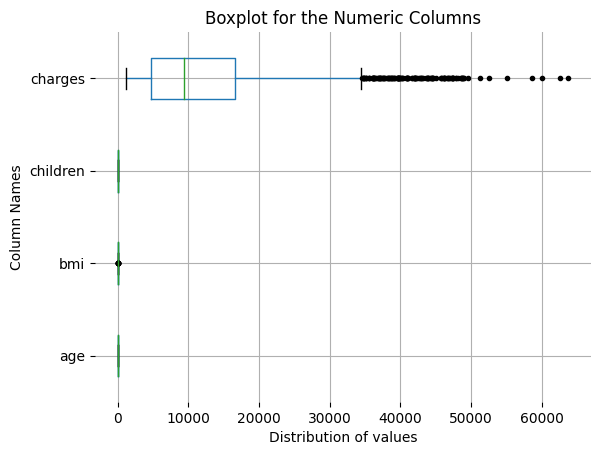

In [25]:
# Drawing boxplots for our numeric dataset, including our output variable
df_insure.boxplot(column= ["age", "bmi", "children", "charges"], vert=False, sym="k.")
plt.suptitle("")
plt.title("Boxplot for the Numeric Columns")
plt.xlabel("Distribution of values")
plt.ylabel("Column Names")
plt.box(False)

First thing of note here is that the charges column has a higher median than the rest of the columns. Also, the outliers in this column reveal that there's deep activity beyond our maximum value. This compels us to keep the outliers. However, we can remove the values that are above 50000 as they seem like rare values.

Secondly, We cannot clearly discern the distribution of children, bmi, and age. Thus, we will draw another chart that excludes the charges column.

In [26]:
# Checking how many values in the charges column are above 50000
len(df_insure[df_insure["charges"] > 50000])

7

In [27]:
# Displaying the rows that are above 50000 in the charges column
df_insure[df_insure["charges"] > 50000]

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,yes,southwest,51194.55914
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
1230,52,male,34.485,3,yes,northwest,60021.39897
1300,45,male,30.360,0,yes,southeast,62592.87309


In [28]:
# Filtering out the seven columns
df_insure = df_insure[df_insure["charges"] <= 50000]
print(f"The dimension of our dataset: {df_insure.shape}")

The dimension of our dataset: (1330, 7)


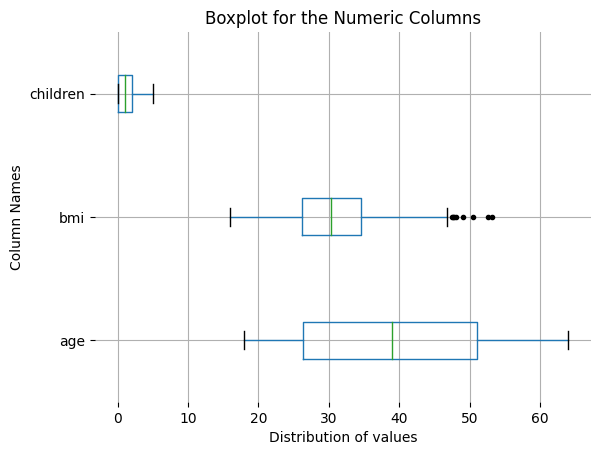

In [29]:
# Sketching boxplots for our numeric columns, excluding the charges column
df_insure.boxplot(column= ["age", "bmi", "children"], vert=False, sym="k.")
plt.title("Boxplot for the Numeric Columns")
plt.xlabel("Distribution of values")
plt.ylabel("Column Names")
plt.box(False)

This is much better! Here, we can see that the age column has a higher median than the other two columns. We will not be removing BMI indices above 47 since the distribution of the column seems to rather resemble Gaussian distribution.

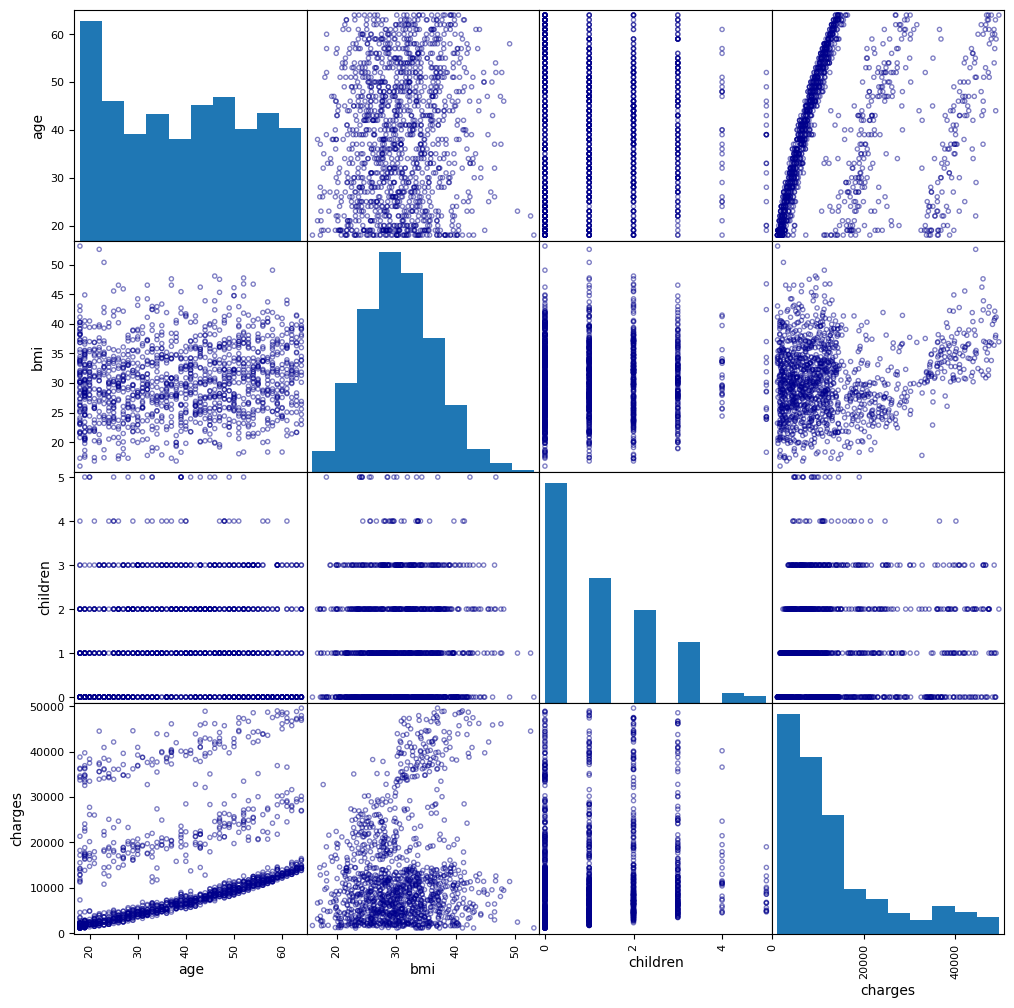

In [30]:
# Plotting correlations for the numeric columns
_ = pd.plotting.scatter_matrix(df_insure, figsize = (12,12), c = "none", edgecolor = "darkblue")

The charges and age columns are correlated. The age distribution has a wide distribution, which would be a flat distribution had the values on the left hand side not been so frequent. Otherwise, the distribution is suggestive of high variance. The distribution of the bmi column is Gaussian. Of note, it's also narrow and tall, suggestive of small variance. The distribution of the charges column is positively skewed.

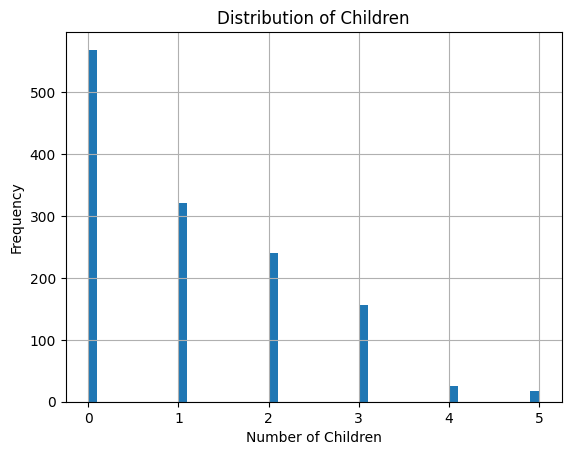

In [31]:
# Zooming in on the children column
df_insure.children.hist(bins=50)
plt.title("Distribution of Children")
plt.ylabel("Frequency")
plt.xlabel("Number of Children")
plt.show()

Customers with no kids are most frequent.

In [32]:
import numpy as np

<AxesSubplot:>

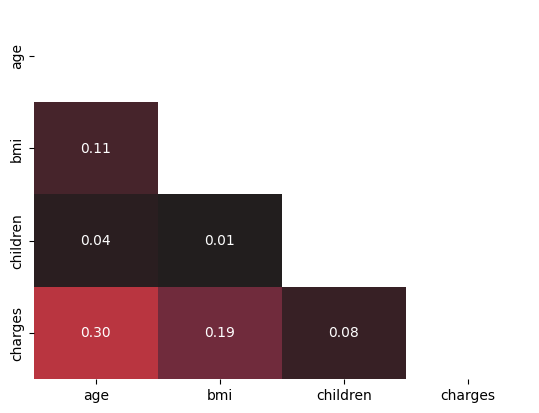

In [33]:
# Plotting correlation values
sns.heatmap(df_insure.corr(), vmin = -0.3, vmax = 0.6, center = 0, annot = True, fmt = ".2f",
            mask = ~np.tri(df_insure.corr().shape[1], k = -1, dtype = bool), cbar = False)

There is low correlation between the age and charges columns. The charges column is not correlated with the bmi and children columns.

In [34]:
from statsmodels.distributions.empirical_distribution import ECDF

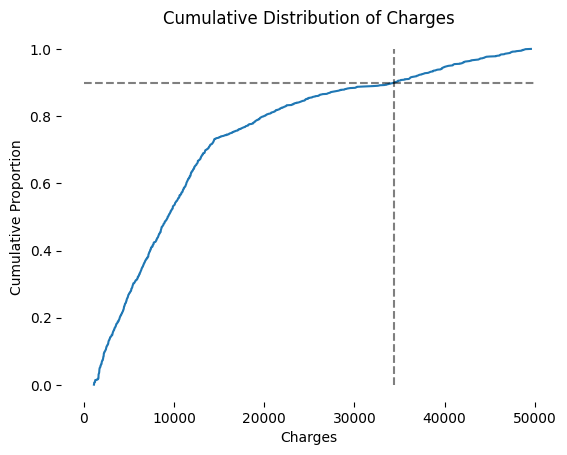

In [35]:
# Plotting cumulative distribution of charges
e = ECDF(df_insure.charges)
plt.subplot(1, 1, 1)
plt.plot(e.x, e.y)
plt.title("Cumulative Distribution of Charges")
plt.ylabel("Cumulative Proportion")
plt.xlabel("Charges")
plt.plot([0, 50000], [0.9, 0.9], "k--", alpha=0.5)
plt.plot([df_insure.charges.quantile(.9), df_insure.charges.quantile(.9)], [0, 1], "k--", alpha=0.5)
plt.box(False)

The dotted lines observed in this cumulative distribution plot emphasize the 90th percentile. The chart identifies that 90% of charges are above 30000 but less than 40000.

Text(0.5, 1.0, 'Region Distribution')

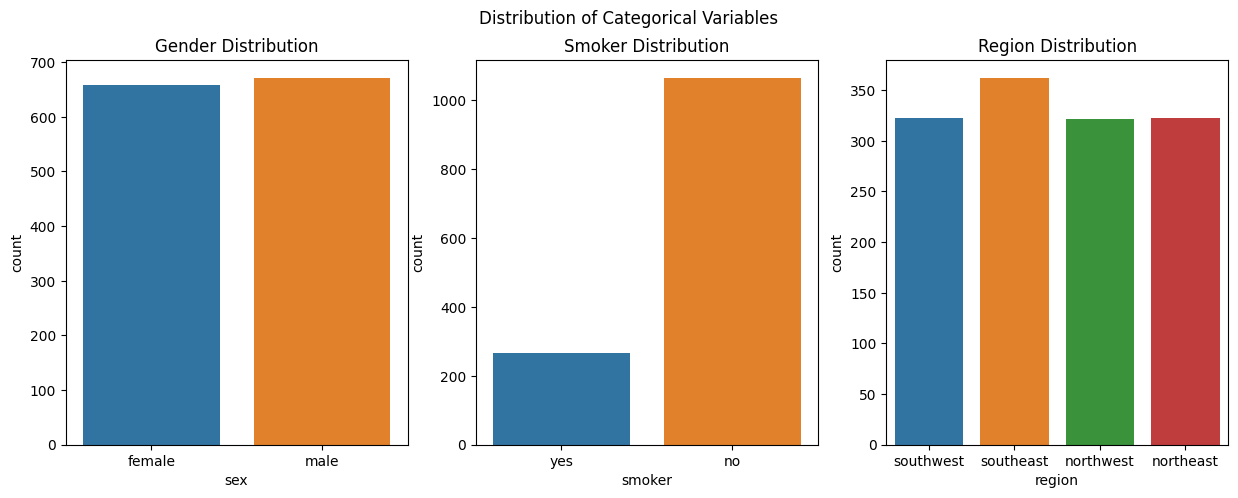

In [36]:
# Plotting distributions of categorical variables
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Distribution of Categorical Variables")

# Plot sex
sns.countplot(ax=axes[0], x=df_insure.sex)
axes[0].set_title("Gender Distribution")

# Plot Smoker
sns.countplot(ax=axes[1], x=df_insure.smoker)
axes[1].set_title("Smoker Distribution")

# Plot Region
sns.countplot(ax=axes[2], x=df_insure.region)
axes[2].set_title("Region Distribution")

As we noticed above, the distribution of males and females is fair, there are more non-smokers compared to smokers, and most of the customers are from the southeast region.

Text(0.5, 1.0, 'BMI vs Charges')

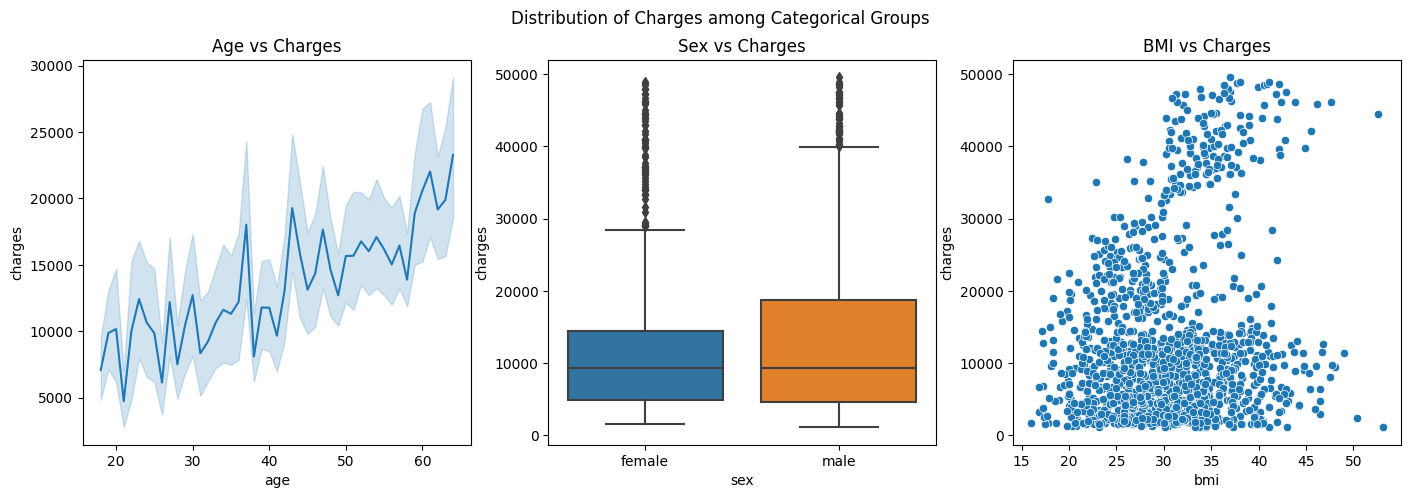

In [37]:
# Plotting distribution of charges among features
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle("Distribution of Charges among Categorical Groups")

# Plot age vs charges
sns.lineplot(ax=axes[0], x=df_insure.age, y=df_insure.charges)
axes[0].set_title("Age vs Charges")

# Plot sex vs charges
sns.boxplot(ax=axes[1], x=df_insure.sex, y=df_insure.charges)
axes[1].set_title("Sex vs Charges")

# Plot bmi vs charges
sns.scatterplot(ax=axes[2], x=df_insure.bmi, y=df_insure.charges)
axes[2].set_title("BMI vs Charges")

Charges against the age variable show an upward trend, suggesting they rise with age. Males and females have the same median value of charges, however, the distribution of charges for males has a larger variance compared to females. For the BMI column, charges are clustered around 10000.

Text(0.5, 1.0, 'Region vs Charges')

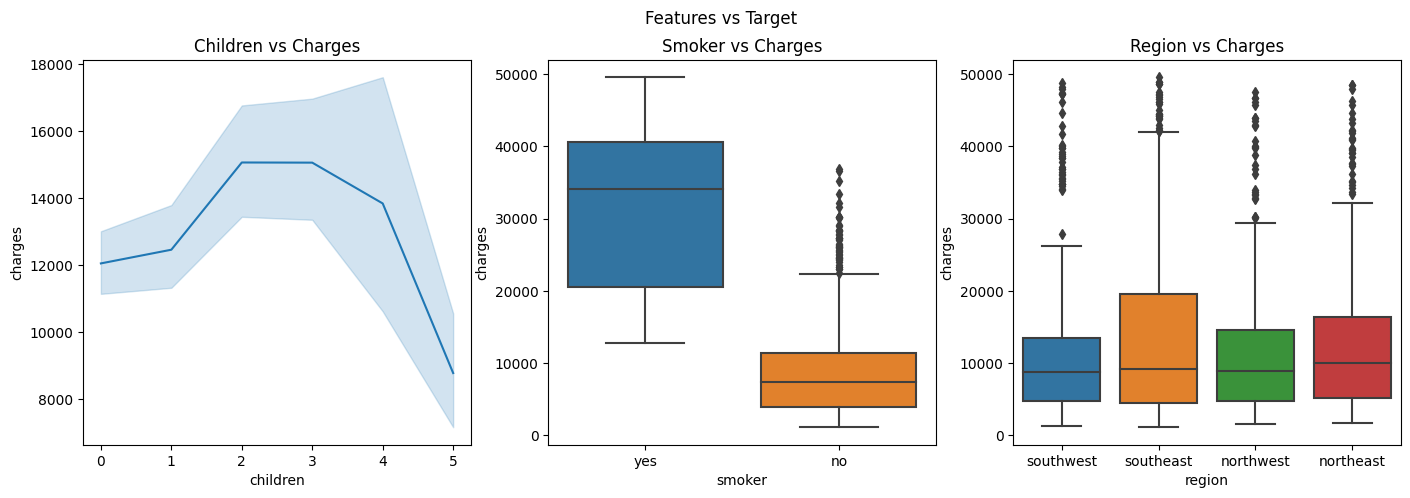

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle("Features vs Target")

# Plot children vs charges
sns.lineplot(ax=axes[0], x=df_insure.children, y=df_insure.charges)
axes[0].set_title("Children vs Charges")

# Plot smoker vs charges
sns.boxplot(ax=axes[1], x=df_insure.smoker, y=df_insure.charges)
axes[1].set_title("Smoker vs Charges")

# Plot region vs charges
sns.boxplot(ax=axes[2], x=df_insure.region, y=df_insure.charges)
axes[2].set_title("Region vs Charges")

Charges are higher for customer with 2 - 3 children, and also higher for smokers. The charges for the northeast region is slightly higher compared to the other regions.

### 4. Modelling

- Feature Encoding

Here we will change the representation of categorical variables to numeric.

In [39]:
# Displaying the columns
df_insure.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [40]:
# Encoding our categorical features
print("Original features:\n", list(df_insure.columns), "\n")
data_dummies = pd.get_dummies(df_insure[["age", "bmi", "children", "region", "charges"]])
data_dummies["sex"] = df_insure["sex"].apply(lambda x: 1 if x == "male" else 0)
data_dummies["smoker"] = df_insure["smoker"].apply(lambda x: 1 if x == "yes" else 0)
print("Features after get_dummies:\n", list(data_dummies.columns))

Original features:
 ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'] 

Features after get_dummies:
 ['age', 'bmi', 'children', 'charges', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'sex', 'smoker']


In [41]:
# Checking out data dimensions
print(f"Dimensions: {data_dummies.shape}\n")

# Having a glimpse at our data after encoding
print(data_dummies.head())

Dimensions: (1330, 10)

   age     bmi  children      charges  region_northeast  region_northwest  \
0   19  27.900         0  16884.92400                 0                 0   
1   18  33.770         1   1725.55230                 0                 0   
2   28  33.000         3   4449.46200                 0                 0   
3   33  22.705         0  21984.47061                 0                 1   
4   32  28.880         0   3866.85520                 0                 1   

   region_southeast  region_southwest  sex  smoker  
0                 0                 1    0       1  
1                 1                 0    1       0  
2                 1                 0    1       0  
3                 0                 0    1       0  
4                 0                 0    1       0  


- Feature Standardization

Numeric features need be standardized so that all numeric features are on the same scale.

In [42]:
# Importing the scaler
from sklearn.preprocessing import StandardScaler

In [43]:
# Scaling our data
scaled_df = data_dummies.copy()
scaler = StandardScaler()
scaled_df[["age", "bmi", "children"]] = scaler.fit_transform(scaled_df[["age", "bmi", "children"]])
print(f"Dimensions: {scaled_df.shape}\n")
print(scaled_df.head())

Dimensions: (1330, 10)

        age       bmi  children      charges  region_northeast  \
0 -1.438072 -0.448866 -0.910496  16884.92400                 0   
1 -1.509261  0.515202 -0.081072   1725.55230                 0   
2 -0.797370  0.388740  1.577778   4449.46200                 0   
3 -0.441425 -1.302075 -0.910496  21984.47061                 0   
4 -0.512614 -0.287915 -0.910496   3866.85520                 0   

   region_northwest  region_southeast  region_southwest  sex  smoker  
0                 0                 0                 1    0       1  
1                 0                 1                 0    1       0  
2                 0                 1                 0    1       0  
3                 1                 0                 0    1       0  
4                 1                 0                 0    1       0  


- Feature Selection

Our objective here is to extract our features.

In [44]:
# Columns for scaled data
scaled_df.columns

Index(['age', 'bmi', 'children', 'charges', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest', 'sex',
       'smoker'],
      dtype='object')

In [45]:
# Extracting features
features = scaled_df[["age", "bmi", "children", "region_northeast", "region_northwest",
                      "region_southeast", "region_southwest", "sex", "smoker"]]

# Extracting NumPy arrays
X = features.values
y = scaled_df["charges"].values
print(f"X.shape: {X.shape} y.shape: {y.shape}")

X.shape: (1330, 9) y.shape: (1330,)


In [46]:
# Importing train_test_split library
from sklearn.model_selection import train_test_split

In [47]:
# Split data into train and test, 80 and 20, respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Our data is ready train models and predict our y-value.


- Linear Regression

In [48]:
# Importing our linear model
from sklearn import linear_model

In [49]:
# Creating our linear regression object
reg = linear_model.LinearRegression()

In [50]:
# Fitting our dataset
reg.fit(X_train, y_train)

LinearRegression()

In [51]:
# Predicting
pred = reg.predict(X_test)

- Decision Tree Regressor

In [52]:
# Importing our DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

In [53]:
# Creating the DecisionTreeRegressor object
regressor = DecisionTreeRegressor(random_state=0)

In [54]:
# Fitting our model
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [55]:
y_pred = regressor.predict(X_test)

- Model Evaluation

We evaluate the accuracy of our models.

In [56]:
# Importing evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [57]:
# Evaluating our linear model
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"R-squared: {r2_score(y_test, pred)}")

RMSE: 5832.496449208681
MAE: 3992.959902058583
R-squared: 0.7592463982942959


In [58]:
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"R-squared: {r2_score(y_test, y_pred)}")

RMSE: 5961.915848208806
MAE: 2641.7489615
R-squared: 0.7484435193153858


Our linear regressor gives a better score than our decision tree regressor. However, our Decision Tree Regressor gives a better MAE. We can improve our models through feature engineering.

In [59]:
# Drawing a table for our models results
scores = {"Model": ["Linear", "Decision Tree"],
          "MAE": [mean_absolute_error(y_test, pred), mean_absolute_error(y_test, y_pred)],
          "RMSE": [np.sqrt(mean_squared_error(y_test, pred)), np.sqrt(mean_squared_error(y_test, y_pred))],
          "R-squared": [r2_score(y_test, pred), r2_score(y_test, y_pred)]}
pd.DataFrame(scores)

,Model,MAE,RMSE,R-squared
0,Linear,3992.959902,5832.496449,0.759246
1,Decision Tree,2641.748961,5961.915848,0.748444


### 5. Model Improvement

- Feature Engineering
    1. We will use KMeans to cluster customers with common characteristics
    2. We will group northeast and northwest in one column, as well as southeast and southwest in another column
    3. We will change the children column to a binary column

In [60]:
# Importing KMeans and the library to find the best clusters
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [61]:
# Getting our columns
data_dummies.columns

Index(['age', 'bmi', 'children', 'charges', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest', 'sex',
       'smoker'],
      dtype='object')

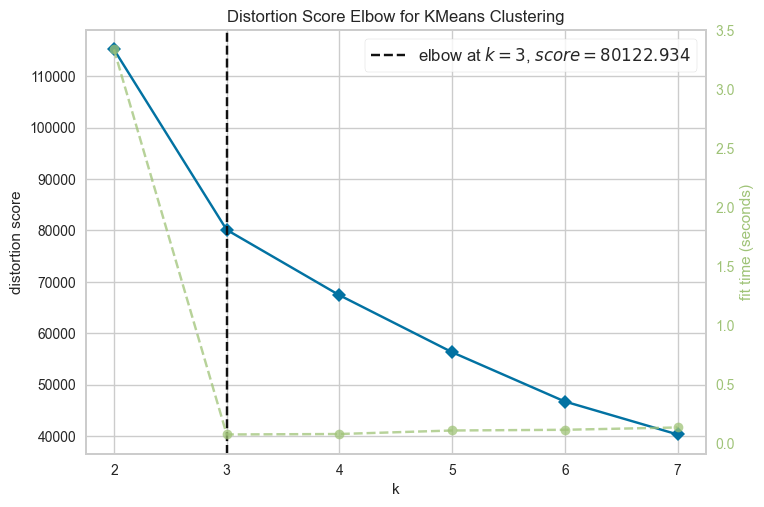

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [62]:
# Extracting the features
features = data_dummies[["age", "bmi", "children", "region_northeast", "region_northwest",
                         "region_southeast", "region_southwest", "sex", "smoker"]]

# Instantiating the clustering model and visualiser
kmeans = KMeans(random_state=0)
visualiser = KElbowVisualizer(kmeans, k = (2, 8))

visualiser.fit(features)    # Fitting the data to the visualiser
visualiser.show()           # Finalizing and rendering the figure

The model fits best at 3 clusters.

In [63]:
# Creating our KMeans object
kmeans = KMeans(n_clusters = 3, random_state=0)

# Fitting our model
kmeans.fit(features)

KMeans(n_clusters=3, random_state=0)

In [64]:
# Adding our clusters to our dataset
data_dummies["clusters"] = kmeans.labels_

# Getting the glimpse of our data
data_dummies.head()

,age,bmi,children,charges,region_northeast,region_northwest,region_southeast,region_southwest,sex,smoker,clusters
0,19,27.900,0,16884.92400,0,0,0,1,0,1,1
1,18,33.770,1,1725.55230,0,0,1,0,1,0,1
2,28,33.000,3,4449.46200,0,0,1,0,1,0,1
3,33,22.705,0,21984.47061,0,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,0,0,1,0,0


In [65]:
# Importing pointbiserialr to check correlations between categorical variables and charges
from scipy.stats import pointbiserialr

In [66]:
# Creating a class that uses pointbiserialr to return correlations and p-values
class Relation:
    """Returns correlations and p-values
    """
    
    # Initiating the class
    def __init__(self, dataset):
        self.dataset = dataset
    
    def rel(self):
        # Creating a specific list for which to return corralations
        list = ["sex", "smoker", "region_northeast", "region_northwest", "region_southeast", "region_southwest", "clusters"]
        
        # The loop checks iterates each category on the list
        for cat in self.dataset:
            
            # The if statement checks whether the category is found on the list
            if cat in list:
                
                # Returning correlations and p-values
                print(cat, pointbiserialr(self.dataset[cat], self.dataset["charges"]))

In [67]:
# Storing correlations and p-values
corr = Relation(data_dummies)

# Printing correlations and p-values
corr.rel()

region_northeast PointbiserialrResult(correlation=0.01071237444146707, pvalue=0.6963034707226011)
region_northwest PointbiserialrResult(correlation=-0.042276519768511, pvalue=0.12330980730916045)
region_southeast PointbiserialrResult(correlation=0.07437614847651007, pvalue=0.006654747740302066)
region_southwest PointbiserialrResult(correlation=-0.045679035852775746, pvalue=0.09587701713365972)
sex PointbiserialrResult(correlation=0.058287161065017766, pvalue=0.033545530983047536)
smoker PointbiserialrResult(correlation=0.7856043852542784, pvalue=3.610865098696241e-279)
clusters PointbiserialrResult(correlation=0.13852806186007194, pvalue=3.942292399164664e-07)


In [68]:
# Creating a class to engineer features
class FeatureEngineering:
    """The class engineers values of categorical variables
    """
    def __init__(self, dataset):
        """Initiating the class
        """
        self.dataset = dataset
    
    def north(self, ne, nw):
        """Binaries to engineer the northeast and northwest values
        """
        if ((ne == 1) | (nw == 1)):
            return 1
        else:
            return 0
    
    def south(self, se, sw):
        """Binaries to engineer the southeast and southwest values
        """
        if ((se == 1) | (sw == 1)):
            return 1
        else:
            return 0

In [69]:
# Creating class inheritance
class Grouping(FeatureEngineering):
    """This class inherits the FeatureEngineering class
    """
    def __init__(self, dataset):
        """Initiating the class
        """
        self.dataset = dataset
    
    def df(self):
        """Enginnering the features
        """
        # Creating one group for the northeast and southeast regions
        self.dataset["northerners"] = self.dataset.apply(lambda x: self.north(x["region_northeast"], x["region_northwest"]), axis=1)
        
        # Creating one group for the southeast and southwest regions
        self.dataset["southerners"] = self.dataset.apply(lambda x: self.south(x["region_southeast"], x["region_southwest"]), axis=1)
        
        # Changing the children variables to a binary variable
        self.dataset[">_1_child"] = self.dataset["children"].apply(lambda x: 1 if x > 1 else 0)
        
        # Returning the first five rows of our updated dataset
        return self.dataset.head()

In [70]:
# Putting it all together
p = Grouping(data_dummies)

In [71]:
# Printing our dataset
p.df()

,age,bmi,children,charges,region_northeast,region_northwest,region_southeast,region_southwest,sex,smoker,clusters,northerners,southerners,>_1_child
0,19,27.900,0,16884.92400,0,0,0,1,0,1,1,0,1,0
1,18,33.770,1,1725.55230,0,0,1,0,1,0,1,0,1,0
2,28,33.000,3,4449.46200,0,0,1,0,1,0,1,0,1,1
3,33,22.705,0,21984.47061,0,1,0,0,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,0,0,1,0,0,1,0,0


In [72]:
# Having a peep at our updated columns
data_dummies.columns

Index(['age', 'bmi', 'children', 'charges', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest', 'sex',
       'smoker', 'clusters', 'northerners', 'southerners', '>_1_child'],
      dtype='object')

In [73]:
# Importing the stats library
from scipy import stats

Our charges column is highly skewed and we will check how it would appear if we were to transform it.

((array([-3.27891911, -3.01980425, -2.87559029, ...,  2.87559029,
          3.01980425,  3.27891911]),
  array([ 1121.8739 ,  1131.5066 ,  1135.9407 , ..., 48885.13561,
         48970.2476 , 49577.6624 ])),
 (10603.658319082728, 13045.345009390227, 0.9047076615609589))

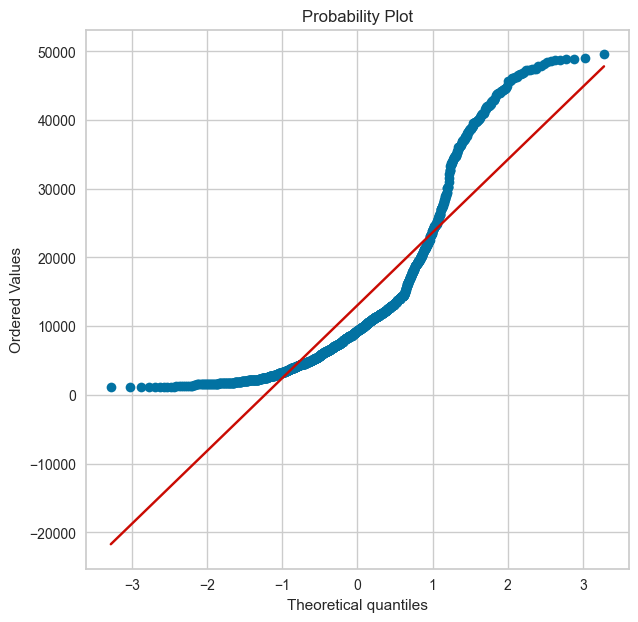

In [74]:
# Checking the distribution of our charges column
plt.figure(figsize=(7,7))
stats.probplot(data_dummies["charges"], dist="norm", plot=plt)

As we can see, it doesn't necessarily conform to a Gaussian distribution. We will check how it behaves if we were to log- and sqrt-transform it.

((array([-3.27891911, -3.01980425, -2.87559029, ...,  2.87559029,
          3.01980425,  3.27891911]),
  array([ 7.02275569,  7.0313053 ,  7.0352164 , ..., 10.79722865,
         10.7989682 , 10.81129566])),
 (0.9048629267862978, 9.090138389317305, 0.9913788892984353))

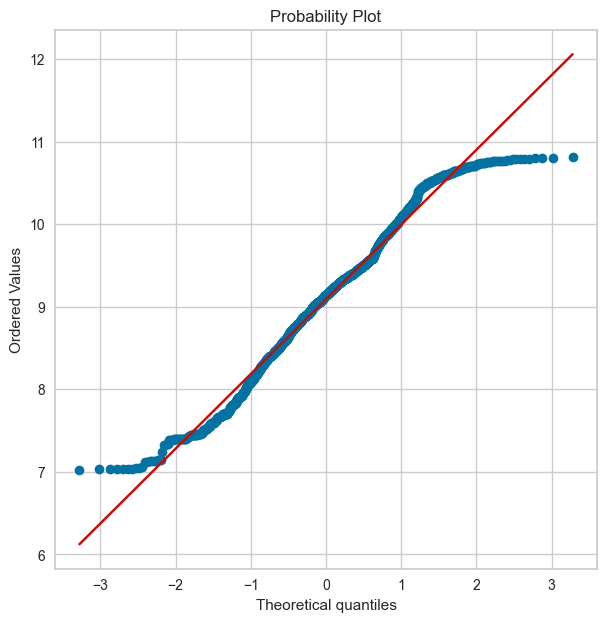

In [75]:
# Log-transforming the charges column
plt.figure(figsize=(7,7))
stats.probplot(np.log(data_dummies["charges"]), dist="norm", plot=plt)

((array([-3.27891911, -3.01980425, -2.87559029, ...,  2.87559029,
          3.01980425,  3.27891911]),
  array([ 33.4943861 ,  33.63787449,  33.70371938, ..., 221.09983177,
         221.29222219, 222.66041947])),
 (45.394359561601654, 104.1704910413635, 0.9670692968504822))

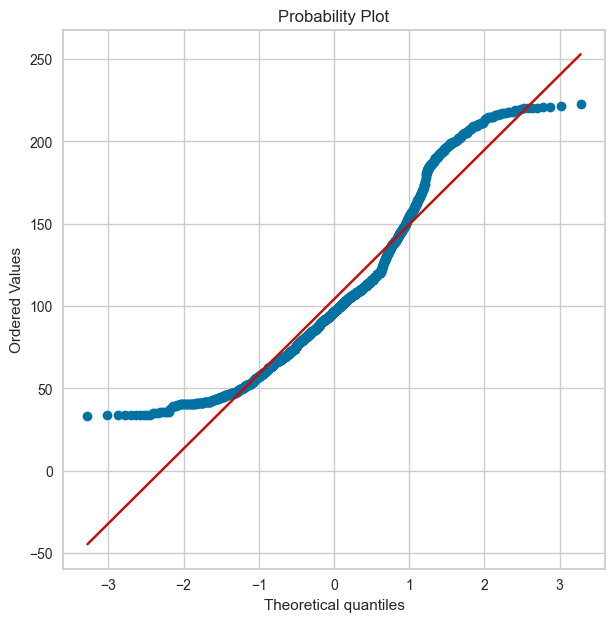

In [76]:
# Sqrt-transforming the charges column
plt.figure(figsize=(7,7))
stats.probplot(np.sqrt(data_dummies["charges"]), dist="norm", plot=plt)

As we can see, it would be much better if we were to log-transform it. However, due to the abundance of outliers, it still does not fall into line perfectly. We will use other means of transformation below.

In [77]:
# Importing libraries to select our best features
from sklearn.feature_selection import SelectKBest, f_regression

In [78]:
# Displaying the columns from which to choose
data_dummies.columns

Index(['age', 'bmi', 'children', 'charges', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest', 'sex',
       'smoker', 'clusters', 'northerners', 'southerners', '>_1_child'],
      dtype='object')

In [79]:
# Extracting our optimized features
features = data_dummies[["age", "bmi", "clusters", "sex", "smoker",
                         "northerners", "southerners", ">_1_child"]]
target = data_dummies["charges"]

# Printing dimensions
print(f"Feature dimension: {features.shape}")

Feature dimension: (1330, 8)


In [80]:
# Selecting the best 7 features
select = SelectKBest(score_func=f_regression, k=7)
z = select.fit_transform(features, target)

# Printing the dimensions
print(f"After selecting best 7 features: {z.shape}")

After selecting best 7 features: (1330, 7)


In [81]:
# Identifying the selected features
data = select.get_support(indices=True)
features_new = features.iloc[:, data]

# Printing our best features
print(f"Best 7 features:\n\n{features_new.columns}")

Best 7 features:

Index(['age', 'bmi', 'clusters', 'sex', 'smoker', 'southerners', '>_1_child'], dtype='object')


In [82]:
# Printing our first two rows of the best-selected features
features_new[0:2]

,age,bmi,clusters,sex,smoker,southerners,>_1_child
0,19,27.90,1,0,1,1,0
1,18,33.77,1,1,0,1,0


In [83]:
# Creating a table for evaluation metrics
metrics = pd.DataFrame()
Model = []
RMSE = []
MAE = []
R_Squared = []

In [84]:
# Extracting dependant and independent variables
y = data_dummies["charges"].values
X = data_dummies[["age", "bmi", "clusters", "sex", "smoker", "southerners", ">_1_child"]]

In [85]:
#Split test and train data
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
# Scaling our categorical features
scaler = StandardScaler()
X_train[["age", "bmi"]] = scaler.fit_transform(X_train[["age", "bmi"]])
X_test[["age", "bmi"]] = scaler.fit_transform(X_test[["age", "bmi"]])

In [87]:
# Importing libraries to transform our data
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

In [92]:
# Creating our linear model
reg = linear_model.LinearRegression()
trans = TransformedTargetRegressor(regressor=reg, transformer=QuantileTransformer(output_distribution="normal"))
trans.fit(X_train, y_train)
pred = trans.predict(X_test)

In [93]:
# Creating our decision tree regressor
regressor = DecisionTreeRegressor(random_state=0)
trans_2 = TransformedTargetRegressor(regressor=regressor, transformer=QuantileTransformer(output_distribution="normal"))
trans_2.fit(X_train, y_train)
y_pred = trans_2.predict(X_test)

In [94]:
# Regression Model Validation
print(f"RMSE: {round(np.sqrt(mean_squared_error(y_test, pred)), 2)}")
print(f"MAE : {round(mean_absolute_error(y_test, pred), 2)}")
print(f"R-squared: {round(r2_score(y_test, pred), 3)}\n")

#DecisionTreeRegressor Model Validation
print(f"RMSE: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}")
print(f"MAE: {round(mean_absolute_error(y_test, y_pred), 2)}")
print(f"R-squared: {round(r2_score(y_test, y_pred), 3)}")

RMSE: 7247.75
MAE : 3948.44
R-squared: 0.627

RMSE: 6528.88
MAE: 3119.49
R-squared: 0.697


### 6. Ensemble and Boosting Algorithms

In [95]:
# Importing RandomForestRegressor and polynomial features
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

In [96]:
# Fitting features
polyF = PolynomialFeatures(degree=3)
X_train_poly = polyF.fit_transform(X_train)
X_test_poly = polyF.fit_transform(X_test)

In [97]:
regr = RandomForestRegressor(max_depth=3, random_state=0)
trans = TransformedTargetRegressor(regressor=regr, transformer=QuantileTransformer(output_distribution="normal"))
trans.fit(X_train_poly, y_train)
pred = trans.predict(X_test_poly)

In [98]:
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"R-squared: {r2_score(y_test, pred)}")

RMSE: 4442.873275008437
MAE: 2319.758989612995
R-squared: 0.8597077724908446


In [99]:
# Importing GrandientBoostingRegressor, xgboost, and lightgbm
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb

In [100]:
def model_boost(x):
    """Generic function to fit model and return metrics for every algorithm"""
    # Transformingtarget variable through quantile transformer
    tt = TransformedTargetRegressor(regressor=x, transformer=QuantileTransformer(output_distribution="normal"))
    tt.fit(X_train, y_train)
    pred = tt.predict(X_test)
    algoname = x.__class__.__name__
    return algoname, round(r2_score(y_test, pred), 3), round(mean_absolute_error(y_test, pred), 2), round(np.sqrt(mean_squared_error(y_test, pred)), 2)

In [101]:
algo = [GradientBoostingRegressor(random_state=0), lgb.LGBMRegressor(), xgb.XGBRFRegressor()]
score = []
for a in algo:
    score.append(model_boost(a))
# Collating all scores in a table
pd.DataFrame(score, columns=["Model", "Score", "MAE", "RMSE"])

,Model,Score,MAE,RMSE
0,GradientBoostingRegressor,0.858,2135.68,4476.40
1,LGBMRegressor,0.853,2323.95,4543.48
2,XGBRFRegressor,0.863,2063.62,4397.33


### 7. Hyperparameter Tuning

In [102]:
# Importing GridSearchCV and SVR
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [103]:
param_grid = {"n_estimators": [100, 80, 60, 50, 45],
              "max_depth": [3, 4, 5, 6],
              "learning_rate": [0.2, 0.15]}

grid = GridSearchCV(lgb.LGBMRegressor(), param_grid, refit = True, verbose = 3, n_jobs = -1)
trans = TransformedTargetRegressor(regressor=grid, transformer=QuantileTransformer(output_distribution="normal"))

# Fitting the model for grid search
result = trans.fit(X_train, y_train)
best_param = result.regressor_.best_params_
print(best_param)

# Using best params to create and fit model
best_model = xgb.XGBRFRegressor(max_depth=best_param["max_depth"], n_estimators=best_param["n_estimators"], reg_lambda=best_param["learning_rate"])
trans = TransformedTargetRegressor(regressor=best_model, transformer=QuantileTransformer(output_distribution="normal"))
trans.fit(X_train, y_train)
pred = trans.predict(X_test)

# Evaluate metrics
r2_score(y_test, pred), mean_absolute_error(y_test, pred), np.sqrt(mean_squared_error(y_test, pred))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 45}


(0.8608665397385, 2245.7318397858908, 4424.486900435597)

In [104]:
param_grid = {"n_estimators": [100, 80, 60, 50, 45],
              "max_depth": [3, 4, 5, 6],
              "num_leaves": [9, 10, 11, 12]}

grid = GridSearchCV(lgb.LGBMRegressor(), param_grid, refit = True, verbose = 3, n_jobs = -1)
trans = TransformedTargetRegressor(regressor=grid, transformer=QuantileTransformer(output_distribution="normal"))

# Fitting the model for grid search
result = trans.fit(X_train, y_train)
best_param = result.regressor_.best_params_
print(best_param)

# Using best params to create and fit model
best_model = xgb.XGBRFRegressor(max_depth=best_param["max_depth"], n_estimators=best_param["n_estimators"], reg_lambda=best_param["num_leaves"])
trans = TransformedTargetRegressor(regressor=best_model, transformer=QuantileTransformer(output_distribution="normal"))
trans.fit(X_train, y_train)
pred = trans.predict(X_test)

# Evaluate metrics
r2_score(y_test, pred), mean_absolute_error(y_test, pred), np.sqrt(mean_squared_error(y_test, pred))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
{'max_depth': 4, 'n_estimators': 50, 'num_leaves': 9}


(0.8527647172476768, 2385.849173443374, 4551.484497779927)

In [105]:
param_grid = {"n_estimators": [100, 80, 60, 50, 45],
              "max_depth": [None, 3, 4, 5, 6]}

grid = GridSearchCV(lgb.LGBMRegressor(), param_grid, refit = True, verbose = 3, n_jobs = -1)
trans = TransformedTargetRegressor(regressor=grid, transformer=QuantileTransformer(output_distribution="normal"))

# Fitting the model for grid search
result = trans.fit(X_train, y_train)
best_param = result.regressor_.best_params_
print(best_param)

# Using best params to create and fit model
best_model = xgb.XGBRFRegressor(max_depth=best_param["max_depth"], n_estimators=best_param["n_estimators"])
trans = TransformedTargetRegressor(regressor=best_model, transformer=QuantileTransformer(output_distribution="normal"))
trans.fit(X_train, y_train)
pred = trans.predict(X_test)

# Evaluate metrics
r2_score(y_test, pred), mean_absolute_error(y_test, pred), np.sqrt(mean_squared_error(y_test, pred))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'max_depth': 3, 'n_estimators': 50}


(0.8614694503218345, 2235.9176888812854, 4414.890121509251)

In [106]:
param_grid = {"n_estimators": [100, 80, 60, 50, 45],
              "max_depth": [3, 4, 5, 6],
              "reg_lambda": [0.26, 0.25, 0.2]}

grid = GridSearchCV(lgb.LGBMRegressor(), param_grid, refit = True, verbose = 3, n_jobs = -1)
trans = TransformedTargetRegressor(regressor=grid, transformer=QuantileTransformer(output_distribution="normal"))

# Fitting the model for grid search
result = trans.fit(X_train, y_train)
best_param = result.regressor_.best_params_
print(best_param)

# Using best params to create and fit model
best_model = xgb.XGBRFRegressor(max_depth=best_param["max_depth"], n_estimators=best_param["n_estimators"], reg_lambda=best_param["reg_lambda"])
trans = TransformedTargetRegressor(regressor=best_model, transformer=QuantileTransformer(output_distribution="normal"))
trans.fit(X_train, y_train)
pred = trans.predict(X_test)

# Evaluate metrics
r2_score(y_test, pred), mean_absolute_error(y_test, pred), np.sqrt(mean_squared_error(y_test, pred))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'max_depth': 3, 'n_estimators': 50, 'reg_lambda': 0.25}


(0.8610207330924848, 2241.213446049107, 4422.034522710844)

In [107]:
model = RandomForestRegressor(max_depth=3, n_estimators = 120, random_state=0)

trans = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution="normal"))
trans.fit(X_train, y_train)
RFRpred = trans.predict(X_test)

Model.append("RandomForestRegressor")
RMSE.append(round(np.sqrt(mean_squared_error(y_test, RFRpred)), 3))
MAE.append(round(mean_absolute_error(y_test, RFRpred), 3))
R_Squared.append(round(r2_score(y_test, RFRpred), 3))

In [108]:
model = xgb.XGBRFRegressor(n_estimators = 120, max_depth = 3, reg_lambda = 0.26)

trans = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution="normal"))
trans.fit(X_train, y_train)
XGBpred = trans.predict(X_test)

Model.append("XGBoost Regression")
RMSE.append(round(np.sqrt(mean_squared_error(y_test, XGBpred)), 3))
MAE.append(round(mean_absolute_error(y_test, XGBpred), 3))
R_Squared.append(round(r2_score(y_test, XGBpred), 3))

In [109]:
model = lgb.LGBMRegressor(n_estimators = 120, max_depth = 3, num_leaves=10)
trans = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution="normal"))
trans.fit(X_train, y_train)
LGBpred = trans.predict(X_test)

Model.append("Light GBM Regression")
RMSE.append(round(np.sqrt(mean_squared_error(y_test, LGBpred)), 3))
MAE.append(round(mean_absolute_error(y_test, LGBpred), 3))
R_Squared.append(round(r2_score(y_test, LGBpred), 3))

#### Metrics Table

In [110]:
metrics["Model"] = Model
metrics["RMSE"] = RMSE
metrics["MAE"] = MAE
metrics["R_Squared"] = R_Squared
#metrics = metrics.drop([3], axis=0)
metrics

,Model,RMSE,MAE,R_Squared
0,RandomForestRegressor,4445.480,2325.106,0.860
1,XGBoost Regression,4401.613,2226.739,0.862
2,Light GBM Regression,4485.802,2187.816,0.857


This is way better! Our accuaracy has improved and the XGBoost returns a score of 86.2%.

In [126]:
# Creating a class to plot y-test vs y-pred
class PlotGraph:
    """The class takes in y-test, y-pred, and regressor name and returns a plot
    """
    def __init__(self, y_test, pred, regressorName):
        """Initiates the class
        """
        self.y_test = y_test
        self.pred = pred
        self.regressorName = regressorName
        
    def graph(self):
        """Plots the graph
        """
        if max(self.y_test) >= max(self.pred):
            my_range = int(max(self.y_test))
        else:
            my_range = int(max(self.pred))
        plt.scatter(range(len(self.y_test)), y_test, color="blue")
        plt.scatter(range(len(self.pred)), pred, color = "red")
        plt.title(self.regressorName)
        plt.show()
        return

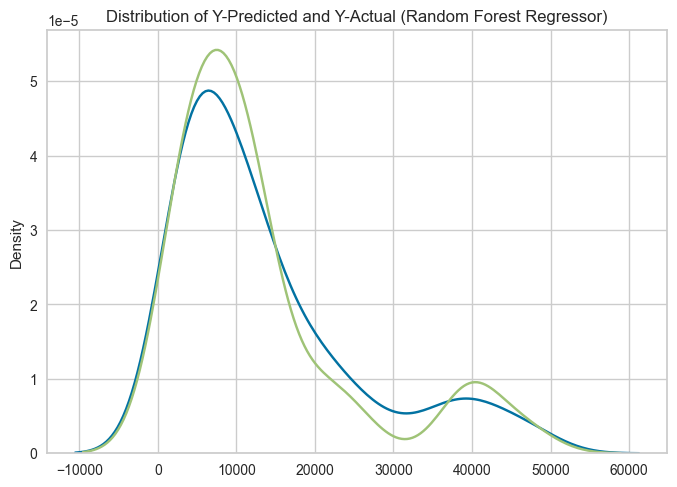

In [112]:
# Ploting distribution for Random Forest Regressor
plt.title("Distribution of Y-Predicted and Y-Actual (Random Forest Regressor)")
axis = sns.distplot(y_test, hist=False)
sns.distplot(RFRpred, hist=False, ax=axis)
plt.show()

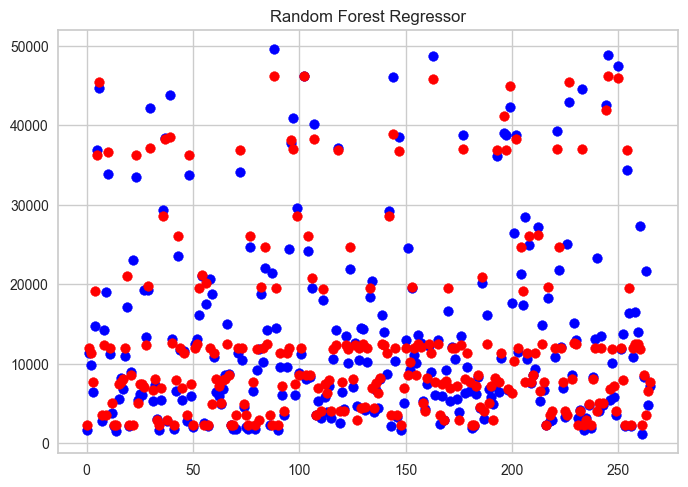

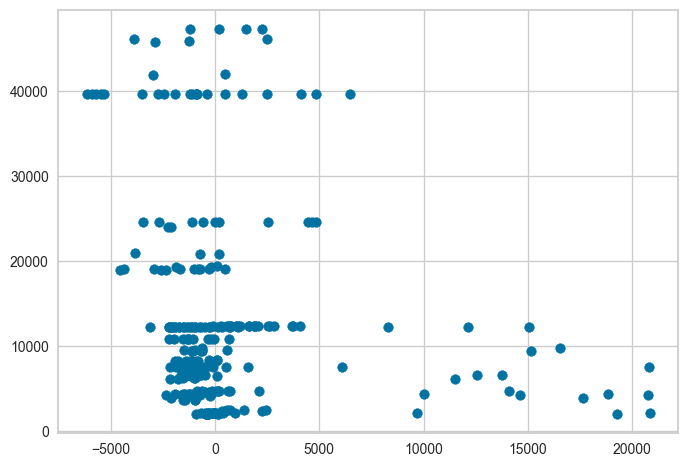

In [127]:
# Scatter and residual plots for Random Forest Regressor
residuals = y_test - RFRpred
p = PlotGraph(y_test, RFRpred, "Random Forest Regressor")
p.graph()
plt.show(plt.scatter(residuals, RFRpred))

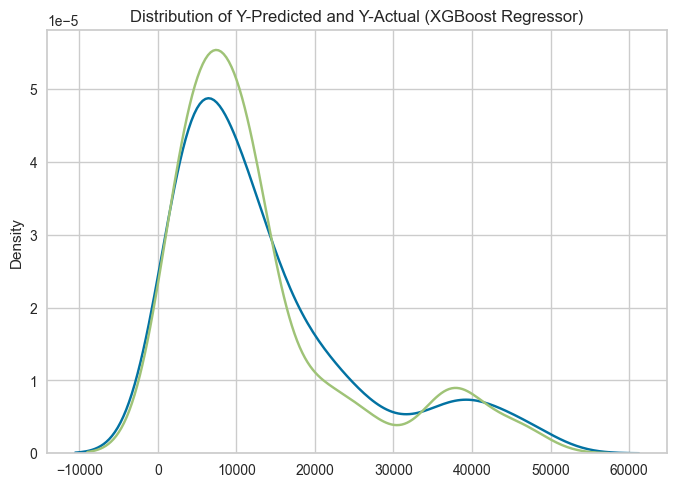

In [128]:
# Ploting distribution for XGBoost Regressor
plt.title("Distribution of Y-Predicted and Y-Actual (XGBoost Regressor)")
axis = sns.distplot(y_test, hist=False)
sns.distplot(XGBpred, hist=False, ax=axis)
plt.show()

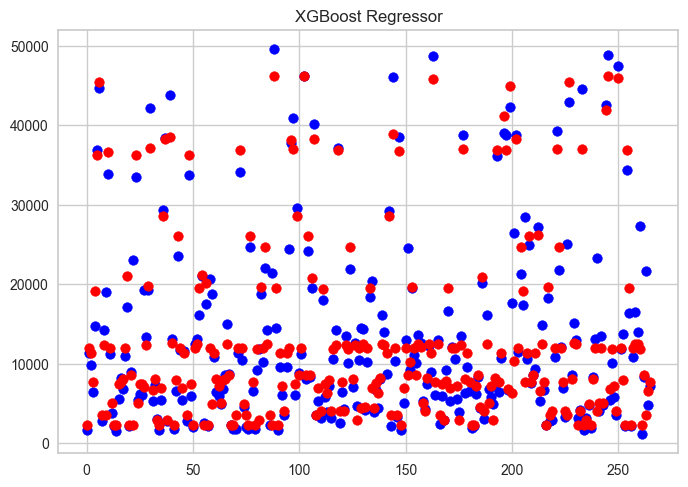

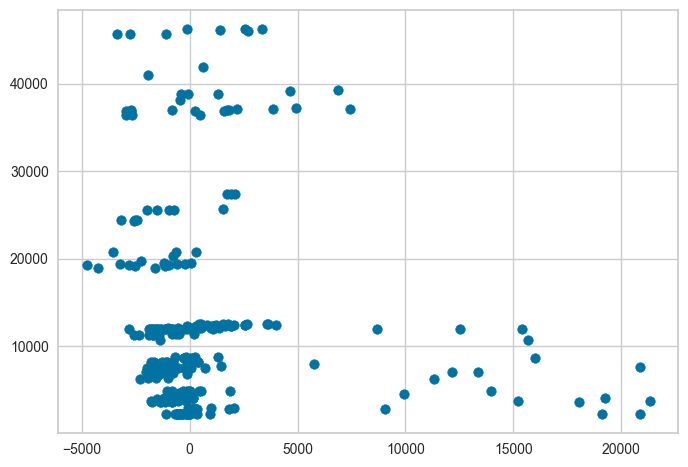

In [131]:
# Scatter and residual plots for XGBoost Regressor
residuals = y_test - XGBpred
p = PlotGraph(y_test, XGBpred, "XGBoost Regressor")
p.graph()
plt.show(plt.scatter(residuals, XGBpred))

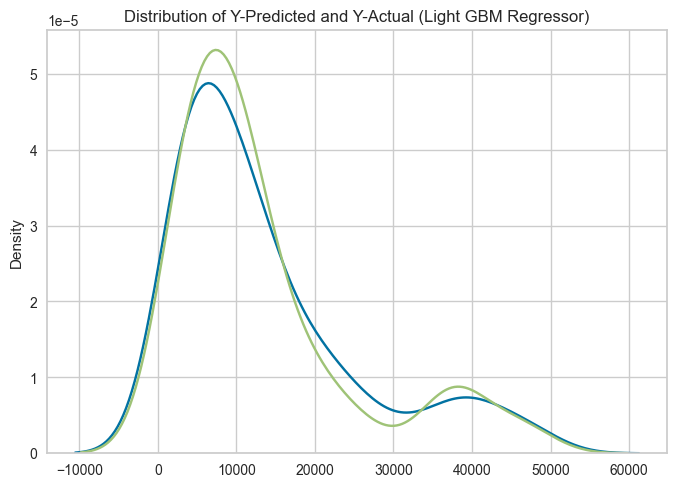

In [132]:
# Ploting distribution for Light GBM Regressor
plt.title("Distribution of Y-Predicted and Y-Actual (Light GBM Regressor)")
axis = sns.distplot(y_test, hist=False)
sns.distplot(LGBpred, hist=False, ax=axis)
plt.show()

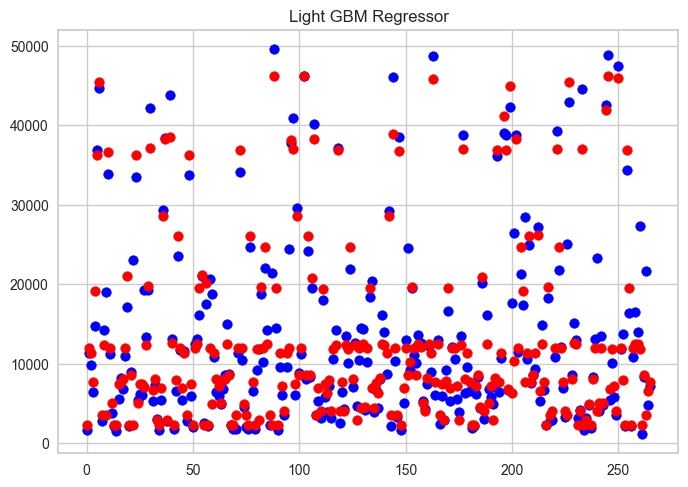

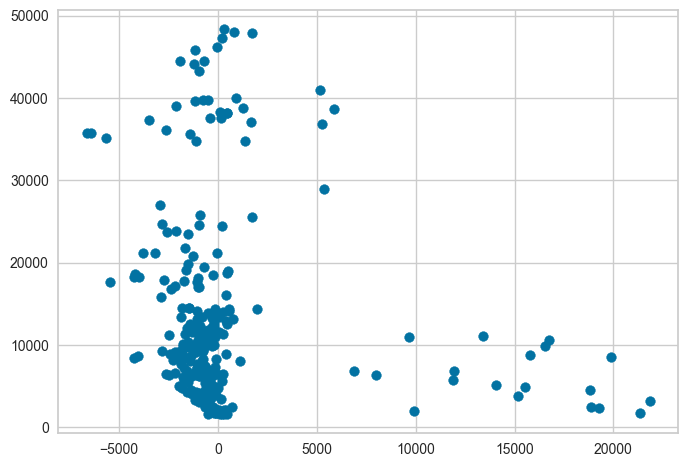

In [133]:
# Scatter and residual plots for Light GBM Regressor
residuals = y_test - LGBpred
p = PlotGraph(y_test, LGBpred, "Light GBM Regressor")
p.graph()
plt.show(plt.scatter(residuals, LGBpred))

Distribution and residual plots serve as proof that a good overlap is observed between predicted and actual charges. Nonetheless, a number of predicted values lie beyond the x-axis, which increases our RMSE. This can be remedied by collecting more data.

The model is ready for deployment.

To summarize, our model was improved by engineering the features, transforming our y-value, grouping similar data through KMeans, employing boosting algorithms, and tuning our hyper-parameters.